## DA-seq 
#### Author: Nicolai Meyerhöfer, modified: Anna Möller
____

In [1]:
library(DAseq)
library(rjson)
library(reticulate)
library(stringr)
pd <- import("pandas")
#' Calculates the individual differentially abundant (DA) cells and clusters for all of the given samples vs the given controls
#'
#' @param controls Dataframe of controls
#' @param patients Dataframe of patients
#' @param save_path Path to save results to
#' @param save_file_name Optional extra filename for saving DA cells and regions
#' @param remove_nrows Optional removal of rows of patient dataframe for validation
#' 


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Warning message:
“package ‘stringr’ was built under R version 4.2.3”


In [2]:
#' Constructs a data frame comprised of all given samples.
#'
#' @param csv_paths CSV paths of all used samples
#' @param labels Labels of samples to use in given csv files
#' @returns data frame comprised of all given samples
read_data <- function(pickle_paths) {
  df <- data.frame()  # Create an empty data frame

  for (pickle_path in pickle_paths) {
    str_list = str_split(pickle_paths, "/") 
    label = basename(pickle_path)
    pickle_data <- pd$read_pickle(pickle_path)  # Read pickle file using reticulate
    pickle_data$label <- rep(label, nrow(pickle_data))
    df <- rbind(df, pickle_data)
    }
  return(df)
}


In [3]:
control_dir <- "/data_slow/je30bery/spatial_proteomics/marker_expression_cell_results/control"
patient_dir <- "/data_slow/je30bery/spatial_proteomics/marker_expression_cell_results/case"

#control_samples <- strsplit(args[3], ",")[[1]] #TODO
#patient_samples <- strsplit(args[4], ",")[[1]] #TODO

r_file_out <- "/data_slow/je30bery/spatial_proteomics/DAseq_results/"
json_file_out <- "/data_slow/je30bery/spatial_proteomics/DAseq_results/"

# Check that the directories exist
if (!file.exists(control_dir) || !file.info(control_dir)$isdir) {
    stop(paste0("Directory does not exist: ", control_dir))
}
if (!file.exists(patient_dir) || !file.info(patient_dir)$isdir) {
    stop(paste0("Directory does not exist: ", patient_dir))
}

# Get CSV filenames
control_files <- list.files(control_dir, "*.pkl", full.names=TRUE)
patient_files <- list.files(patient_dir, "*.pkl", full.names=TRUE)

# Read data
control_data <- read_data(control_files)
if (is.null(control_data)) {
    warning(paste0("No pickle files found in ", control_dir))
}
patient_data <- read_data(patient_files)
if (is.null(patient_data)) {
    warning(paste0("No pickle files found in ", patient_dir))
}

# Calculate clusters
#calculate_DA_clusters(controls = control_data, patients = patient_data,
#                       save_path = r_file_out, json_save_path = json_file_out)

In [4]:
controls <- control_data
patients <- patient_data
save_path = r_file_out
json_save_path = json_file_out
save_file_name = ""

runFItSNE <- function(data, seed.use = 0, reduction.name = "tsne", reduction.key = "tSNE_",
                        fast.R.path = "/data_slow/je30bery/DAseq-master/FIt-SNE/fast_tsne.R", ...)
{
    current.dir <- getwd()
    source(fast.R.path, chdir = T)
    X.out <- fftRtsne(X = data, rand_seed = seed.use, ...)
    setwd(current.dir)
    return(X.out)
}


ids_controls <- controls[,ncol(controls)]
ids_patients <- patients[,ncol(patients)]


In [5]:
sample_id = 'all'

In [6]:
df_new_tmp <- rbind(controls, patients)
df_new <- df_new_tmp[,1:ncol(df_new_tmp)-1]
df_new <- sapply(df_new, as.numeric)

df.scaled <- scale(df_new)
data_tsne <- runFItSNE(df.scaled)
data_tsne.col <- ncol(data_tsne)

colnames(data_tsne) <- paste("tSNE_", c(1:data_tsne.col), sep="")
rownames(data_tsne) <- rownames(df.scaled)

cell_labels <- as.character(df_new_tmp[, ncol(df_new_tmp)])
#print(cell_labels)
labels_1 <- as.character(ids_patients[!duplicated(ids_patients)])
labels_2 <- as.character(ids_controls[!duplicated(ids_controls)])

df_scaled <- as.data.frame(df.scaled)

FIt-SNE R wrapper loading.

FIt-SNE root directory was set to /data_slow/je30bery/DAseq-master/FIt-SNE

Using irlba() to compute the top PCs for initialization.



In [7]:
da_cells <- getDAcells(
        X = df_scaled,
        cell.labels = cell_labels,
        labels.1 = labels_1,
        labels.2 = labels_2,
        k.vector = seq(50, 500, 50),
        plot.embedding = data_tsne
)

Turning X to a matrix.
Calculating DA score vector.
Running GLM.
Test on random labels.
Setting thresholds based on permutation


In [8]:
da_cells <- updateDAcells(
        X = da_cells,
        pred.thres = c(-0.8,0.8),
        do.plot = T,
        plot.embedding = data_tsne,
        size = 0.1
)

In [9]:
da_cells$cell.idx

[1]     1     2     3     4     5     6     7     8     9    10    11    12
   [13]    13    14    15    16    17    18    19    20    21    22    23    24
   [25]    25    26    27    28    29    30    31    32    33    34    35    36
   [37]    37    38    39    40    41    42    43    44    45    46    47    48
   [49]    49    50    51    52    53    54    55    56    57    58    59    60
   [61]    61    62    63    64    65    66    67    68    69    70    71    72
   [73]    73    74    75    76    77    78    79    80    81    82    83    84
   [85]    85    86    87    88    89    90    91    92    93    94    95    96
   [97]    97    98    99   100   101   102   103   104   105   106   107   108
  [109]   109   110   111   112   113   114   115   116   117   118   119   120
  [121]   121   122   123   124   125   126   127   128   129   130   131   132
  [133]   133   134   135   136   137   138   139   140   141   142   143   144
  [145]   145   146   147   148   149   150   151   152   153   154   155   156
  [157]   157   158   159   160   161   162   163   164   165   166   167   168
  [169]   169   170   171   172   173   174   175   176   177   178   179   180
  [181]   181   182   183   184   185   186   187   188   189   190   191   192
  [193]   193   194   195   196   197   198   199   200   201   202   203   204
  [205]   205   206   207   208   209   210   211   212   213   214   215   216
  [217]   217   218   219   220   221   222   223   224   225   226   227   228
  [229]   229   230   231   232   233   234   235   236   237   238   239   240
  [241]   241   242   243   244   245   246   247   248   249   250   251   252
  [253]   253   254   255   256   257   258   259   260   261   262   263   264
  [265]   265   266   267   268   269   270   271   272   273   274   275   276
  [277]   277   278   279   280   281   282   283   284   285   286   287   288
  [289]   289   290   291   292   293   294   295   296   297   298   299   300
  [301]   301   302   303   304   305   306   307   308   309   310   311   312
  [313]   313   314   315   316   317   318   319   320   321   322   323   324
  [325]   325   326   327   328   329   330   331   332   333   334   335   336
  [337]   337   338   339   340   341   342   343   344   345   346   347   348
  [349]   349   350   351   352   353   354   355   356   357   358   359   360
  [361]   361   362   363   364   365   366   367   368   369   370   371   372
  [373]   373   374   375   376   377   378   379   380   381   382   383   384
  [385]   385   386   387   388   389   390   391   392   393   394   395   396
  [397]   397   398   399   400   401   402   403   404   405   406   407   408
  [409]   409   410   411   412   413   414   415   416   417   418   419   420
  [421]   421   422   423   424   425   426   427   428   429   430   431   432
  [433]   433   434   435   436   437   438   439   440   441   442   443   444
  [445]   445   446   447   448   449   450   451   452   453   454   455   456
  [457]   457   458   459   460   461   462   463   464   465   466   467   468
  [469]   469   470   471   472   473   474   475   476   477   478   479   480
  [481]   481   482   483   484   485   486   487   488   489   490   491   492
  [493]   493   494   495   496   497   498   499   500   501   502   503   504
  [505]   505   506   507   508   509   510   511   512   513   514   515   516
  [517]   517   518   519   520   521   522   523   524   525   526   527   528
  [529]   529   530   531   532   533   534   535   536   537   538   539   540
  [541]   541   542   543   544   545   546   547   548   549   550   551   552
  [553]   553   554   555   556   557   558   559   560   561   562   563   564
  [565]   565   566   567   568   569   570   571   572   573   574   575   576
  [577]   577   578   579   580   581   582   583   584   585   586   587   588
  [589]   589   590   591   592   593   594   595   596   597   598   599   600
  [6

In [10]:
f <- paste(save_path, "da_cells_", save_file_name, sample_id, ".rds", sep="")
saveRDS(da_cells, f)

da_regions <- getDAregion(
        X = df.scaled,
        da.cells = da_cells,
        cell.labels = df_new_tmp[,ncol(df_new_tmp)],
        labels.1 = ids_patients[!duplicated(ids_patients)],
        labels.2 = ids_controls[!duplicated(ids_controls)],
        resolution = 0.01,
        min.cell = 50,
        plot.embedding = data_tsne,
        size = 0.1
)

Removing 10 DA regions with cells < 50.


Warning message in wilcox.test.default(x = idx.label.ratio[labels.2], idx.label.ratio[labels.1]):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = idx.label.ratio[labels.2], idx.label.ratio[labels.1]):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = idx.label.ratio[labels.2], idx.label.ratio[labels.1]):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = idx.label.ratio[labels.2], idx.label.ratio[labels.1]):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = idx.label.ratio[labels.2], idx.label.ratio[labels.1]):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = idx.label.ratio[labels.2], idx.label.ratio[labels.1]):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(x = idx.label.ratio[labels.2], idx.label.ratio[labels.1]):
“cannot compute exact p-value with ties”


In [11]:
options(max.print = 190000)
capture.output(da_regions$da.region.label, file = "DA_regions_cells.txt")

In [12]:
#
#f <- paste(save_path, "da_regions_cells_", save_file_name, sample_id, ".rds", sep="")
#saveRDS(da_regions, f)


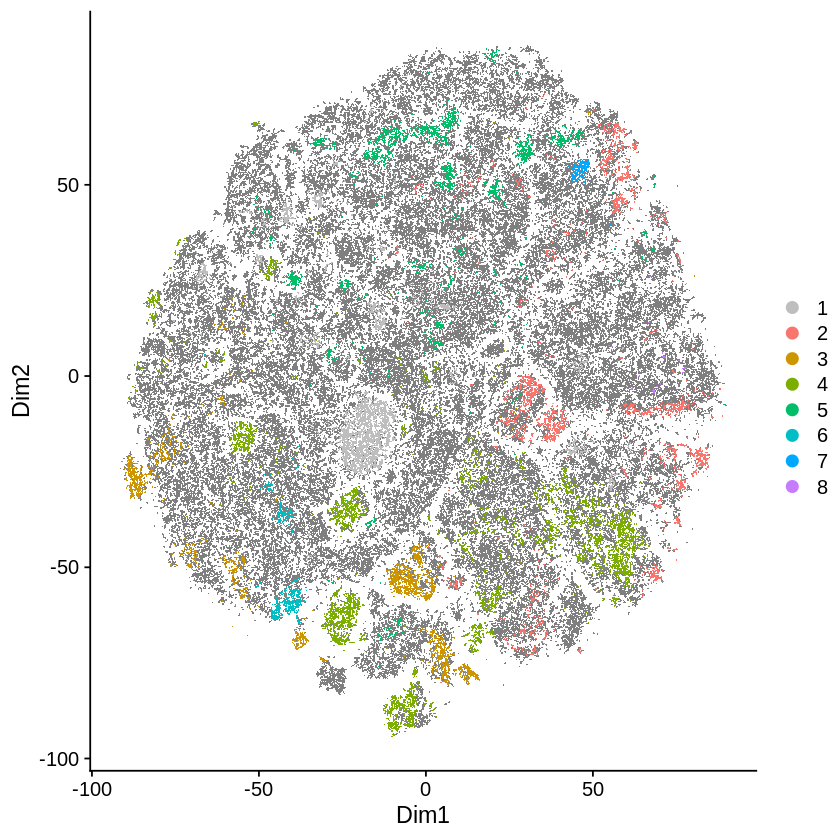

In [13]:
da_regions$da.region.plot

In [14]:

# writing the json file
da_cluster_name <- sample_id
cluster_labels <- which(da_regions$DA.stat[,1] < 0)

da_cluster_purities <- list(da_regions$DA.stat[cluster_labels])	
da_cluster_cells_tmp <- list()
da_cluster_sizes_tmp <- c()
    for(cluster_label in cluster_labels){
    cells <- which(da_regions$da.region.label == cluster_label)
    # indices -1 to fit python indices because R counts indices from 1 :D 
    for(i in 1:length(cells)){
        cells[i] <- cells[i] - 1
    }
    da_cluster_cells_tmp <- append(da_cluster_cells_tmp, list(cells))
    da_cluster_sizes_tmp <- c(da_cluster_sizes_tmp, length(cells))
}
    da_cluster_sizes <- list(da_cluster_sizes_tmp)	
da_cluster_cells <- list(da_cluster_cells_tmp)
json_df <- data.frame(da_cluster_name)
json_clusters <- data.frame(Sizes = I(da_cluster_sizes), Purities = I(da_cluster_purities), DA_Cells = I(da_cluster_cells))
json_df$Clusters <- json_clusters
json_file <- toJSON(json_df)
write(json_file, file = paste(json_save_path, sample_id, "_clusters.json", sep="", collapse=NULL))

In [ ]:
library(stageR)

STG_markers <- STGmarkerFinder(
  X = t(df_new),
  da.regions = da_regions,
  lambda = 1.5, n.runs = 5, return.model = T,
  python.use = "/data/je30bery/.conda/envs/seurat/bin/python", GPU=0
)

In [ ]:
n <- df_new$name

# transpose all but the first column (name)
df_new_t <- as.data.frame(t(df_new[,-1]))
colnames(df_new_t) <- n
df_new_t$myfactor <- factor(row.names(df_new))

str(df_new_t) # Check the column types


In [ ]:
write.csv(df_new_tmp, "df_new_temp.csv", row.names=TRUE)

In [ ]:
df_new